In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [6]:
import matplotlib.pyplot as plt

In [2]:
class VariousAutoencoder(nn.Module):
    @classmethod
    def __init__(self, in_features, out_features):
        self.mean_weights = nn.Linear(in_features, out_features)
        self.z_std_weights = nn.Linear(in_features, out_features)
        self.in_features = in_features
        self.out_features = out_features
    
    @classmethod
    def forward(self, x, dkl_loss=True):
        z_mean = self.mean_weights(x)
        eps = torch.randn(len(x), self.out_features)
        z_std = self.z_std_weights(x)
        
        z = z_mean + z_std.exp().sqrt() * eps
        
        if dkl_loss:
            loss = -0.5 * (1 + z_std - z_mean ** 2 - z_std.exp()).sum(1)
            return z, loss
        
        return z

In [46]:
class Generator(nn.Module):
    def __init__(self, in_features=100, out_features=100, activation=nn.ReLU(inplace=True)):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(in_features, 500),
            activation,
            nn.Linear(500, 501),
            activation,
            nn.Linear(501, out_features)
        )

    def forward(self, x):
        return self.model(x)

In [47]:
class Discriminator(nn.Module):
    def __init__(self, in_features=100, activation=nn.LeakyReLU(inplace=True)):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(in_features, 500),
            activation,
            nn.Linear(500, 501),
            activation,
            nn.Linear(501, 1)
        )
    
    def forward(self, x):
        return self.model(x)

In [98]:
def train_gan(G, D, G_optimizer, D_optimizer, data_loader, fake_loader, log_interval=200):
    G.train()
    D.train()
    
    for batch, (data, random_sample) in enumerate(zip(data_loader, fake_loader)):
        G.zero_grad()
        D.zero_grad()

        fake_pred = D(G(random_sample))
        true_pred = D(data)

        fake_loss = nn.functional.binary_cross_entropy_with_logits(fake_pred, torch.zeros(len(random_sample), 1))
        true_loss = nn.functional.binary_cross_entropy_with_logits(true_pred, torch.ones(len(data), 1))

        D_loss = 0.5 * (fake_loss + true_loss)

        D_loss.backward()
        D_optimizer.step()

        G.zero_grad()
        D.zero_grad()

        fake_pred = D(G(random_sample))
        G_loss = nn.functional.binary_cross_entropy_with_logits(fake_pred, torch.ones(len(random_sample), 1))

        G_loss.backward()
        G_optimizer.step()

        if batch % log_interval == 0:
            print('[Batch {}/{}]\tLosses: G: {:.4f} D: {:.4f}'.format(batch, len(data_loader), G_loss.item(), D_loss.item()))

In [99]:
class RandomSampleLoader:
    def __init__(self, distribution=None, sample_len=100, batches=20, batch_size=64):
        self.distribution = distribution if distribution else torch.distributions.Normal(0, 1)
        self.batches = batches
        self.batch_size = batch_size
        self.sample_len = sample_len
        
    def __iter__(self):
        for i in range(self.batches):
            yield self.distribution.sample((self.batch_size, self.sample_len))
    
    def __len__(self):
        return self.batches

In [100]:
def test_gan(G, D, data_loader, fake_loader):
    G.eval()
    D.eval()
    
    G_losses = []
    D_losses = []
    with torch.no_grad():
        for data, random_sample in zip(test_data_loader, test_fake_loader):
            true_pred = D(data)
            fake_pred = D(G(random_sample))
            
            true_loss = loss_func(true_pred, torch.ones(len(data), 1)).item()
            fake_loss = loss_func(fake_pred, torch.zeros(len(random_sample), 1)).item()
            D_loss = (true_loss + fake_loss) * 0.5
            D_losses.append(D_loss)
            
            G_loss = loss_func(fake_pred, torch.ones(len(random_sample), 1)).item()
            G_losses.append(G_loss)
    
    print('Test losses: G: {:.4f} D: {:.4f}'.format(np.mean(G_losses), np.mean(D_losses)))

In [122]:
fake_distribution = torch.distributions.Uniform(-1, 1)
batch_size = 64
batches = 150

train_data_loader = RandomSampleLoader(batch_size=batch_size, batches=batches)
train_fake_loader = RandomSampleLoader(fake_distribution, batch_size=batch_size, batches=batches)

test_batches = 2
test_data_loader = RandomSampleLoader(batches=test_batches, batch_size=batch_size)
test_fake_loader = RandomSampleLoader(fake_distribution, batches=test_batches, batch_size=batch_size)

loss_func = nn.functional.binary_cross_entropy_with_logits

lr = 1e-4
G = Generator()
D = Discriminator()
G_optimizer = optim.Adam(G.parameters(), lr)
D_optimizer = optim.Adam(D.parameters(), lr)

In [123]:
def show_samples(samples, subplot_size=(3, 5)):
    fig, axs = plt.subplots(*subplot_size, figsize=(15, 6))
    for row, ax in zip(samples, axs.flat):
        ax.hist(row, range=(-3, 3), bins=12)
    plt.show()

def start_train_gan(G, D, G_optimizer, D_optimizer, epochs=5):
    
    for epoch in range(epochs):
        print("Epoch {}".format(epoch))
        
        train_gan(G, D, G_optimizer, D_optimizer, train_data_loader, train_fake_loader, log_interval=50)
        test_gan(G, D, test_data_loader, test_fake_loader)
        
        z = next(iter(test_fake_loader))
        with torch.no_grad():
            samples = G(z).numpy()
        
        show_samples(samples)

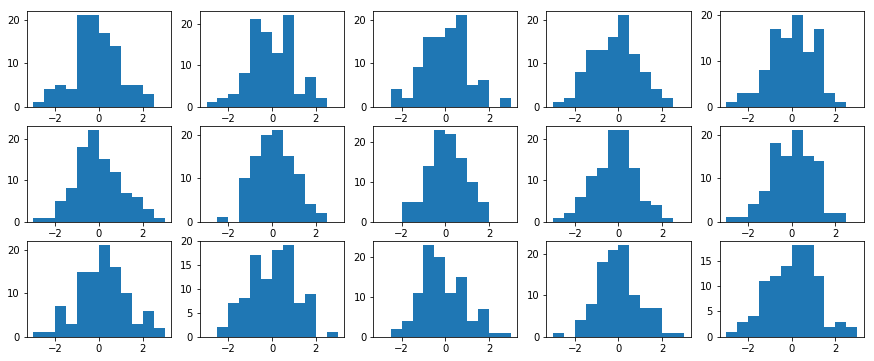

In [124]:
show_samples(next(iter(test_data_loader)))

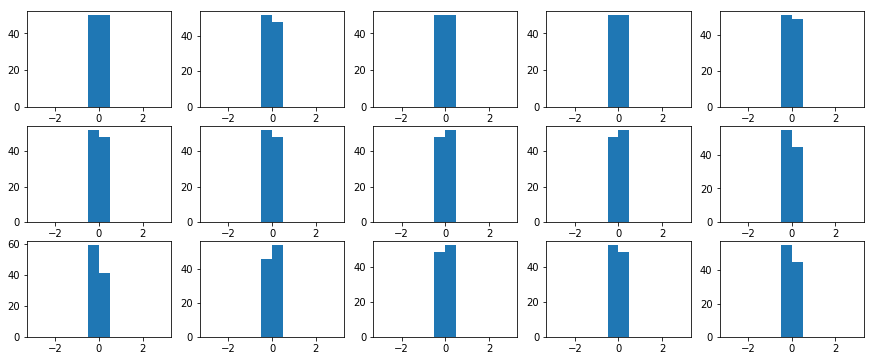

In [125]:
z = next(iter(test_fake_loader))
with torch.no_grad():
    show_samples(G(z))

Epoch 0
[Batch 0/150]	Losses: G: 0.6800 D: 0.7162
[Batch 50/150]	Losses: G: 0.7152 D: 0.4134
[Batch 100/150]	Losses: G: 1.0274 D: 0.3088
Test losses: G: 0.9404 D: 0.3549


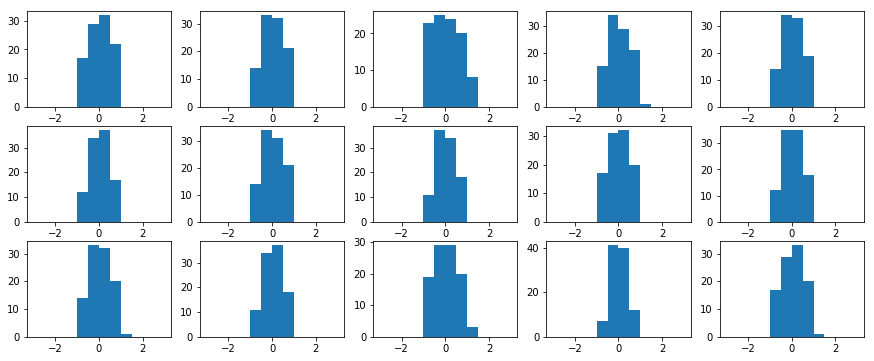

Epoch 1
[Batch 0/150]	Losses: G: 1.0897 D: 0.3356
[Batch 50/150]	Losses: G: 1.4310 D: 0.2662
[Batch 100/150]	Losses: G: 1.8164 D: 0.1959
Test losses: G: 1.4524 D: 0.2182


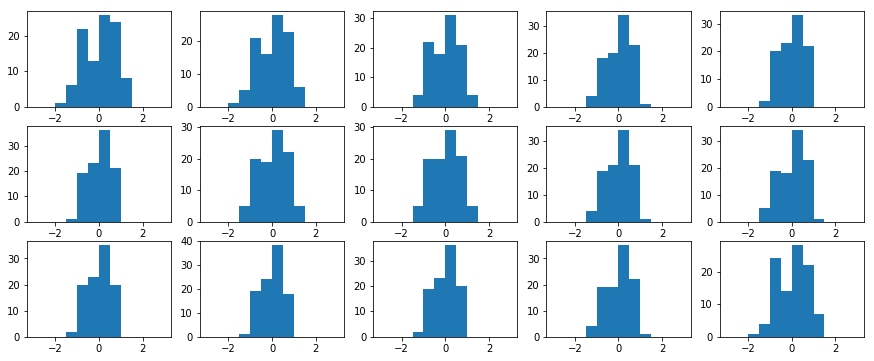

Epoch 2
[Batch 0/150]	Losses: G: 1.8086 D: 0.2317
[Batch 50/150]	Losses: G: 2.3349 D: 0.1374
[Batch 100/150]	Losses: G: 2.8628 D: 0.1444
Test losses: G: 2.5322 D: 0.0808


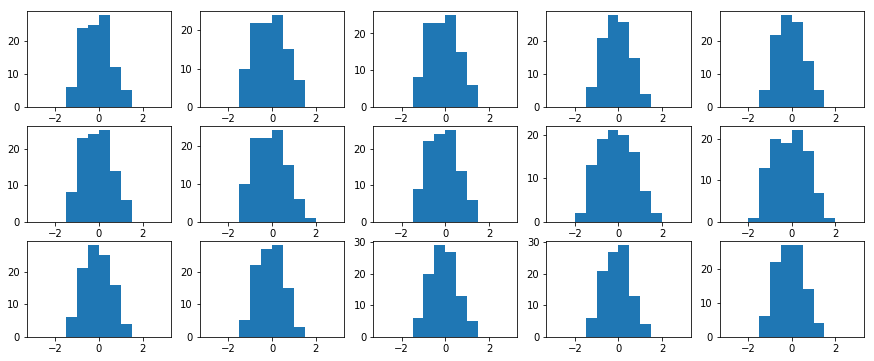

Epoch 3
[Batch 0/150]	Losses: G: 2.8929 D: 0.0659
[Batch 50/150]	Losses: G: 3.0579 D: 0.0964
[Batch 100/150]	Losses: G: 3.2675 D: 0.0465
Test losses: G: 2.6918 D: 0.0475


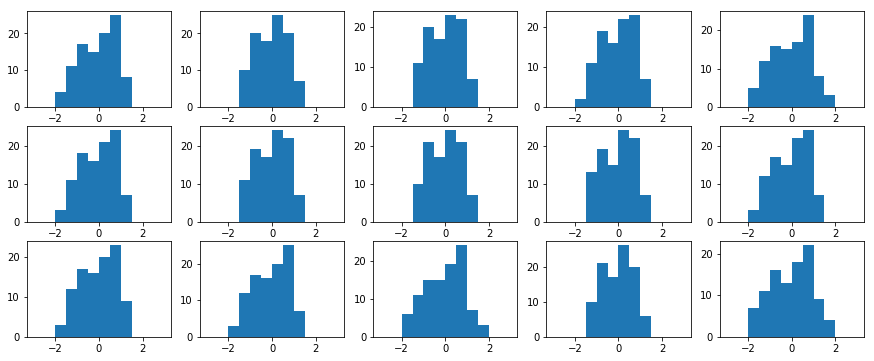

Epoch 4
[Batch 0/150]	Losses: G: 3.3486 D: 0.0439
[Batch 50/150]	Losses: G: 3.9826 D: 0.1465
[Batch 100/150]	Losses: G: 4.1694 D: 0.0448
Test losses: G: 3.0284 D: 0.0424


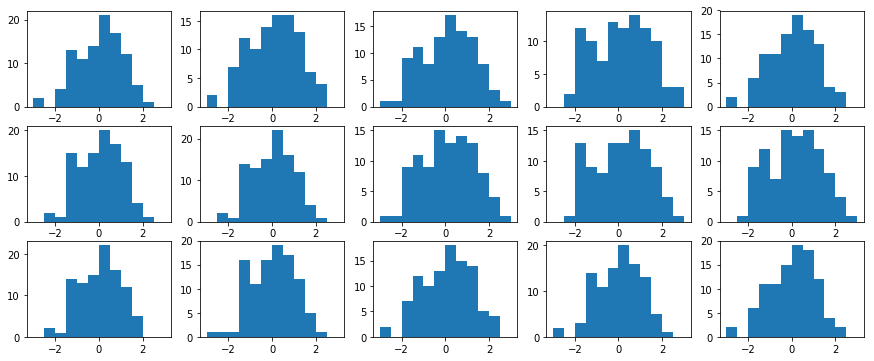

Epoch 5
[Batch 0/150]	Losses: G: 4.1510 D: 0.1101
[Batch 50/150]	Losses: G: 4.7745 D: 0.0178
[Batch 100/150]	Losses: G: 4.8040 D: 0.0200
Test losses: G: 4.1063 D: 0.0460


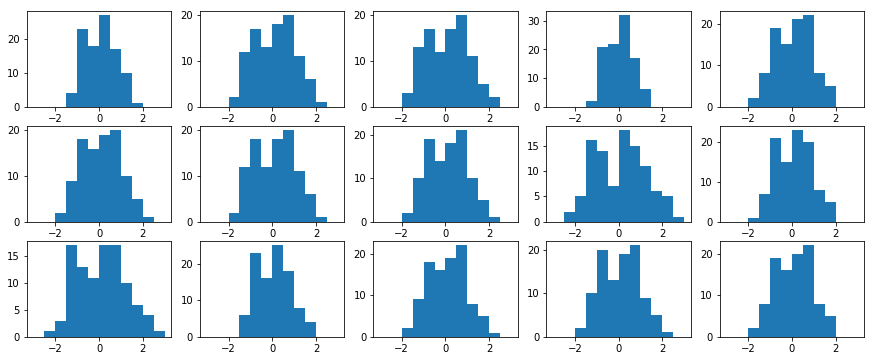

Epoch 6
[Batch 0/150]	Losses: G: 4.6933 D: 0.0416
[Batch 50/150]	Losses: G: 4.4845 D: 0.0190
[Batch 100/150]	Losses: G: 4.2647 D: 0.0167
Test losses: G: 3.5545 D: 0.0418


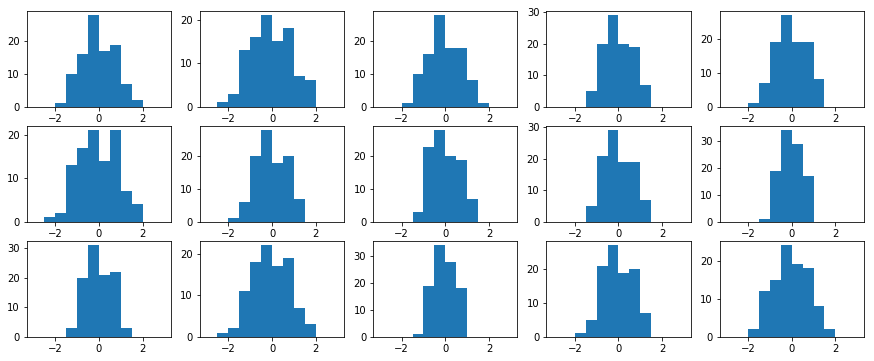

Epoch 7
[Batch 0/150]	Losses: G: 4.1294 D: 0.0181
[Batch 50/150]	Losses: G: 4.0128 D: 0.0367
[Batch 100/150]	Losses: G: 4.0452 D: 0.0186
Test losses: G: 3.8450 D: 0.0260


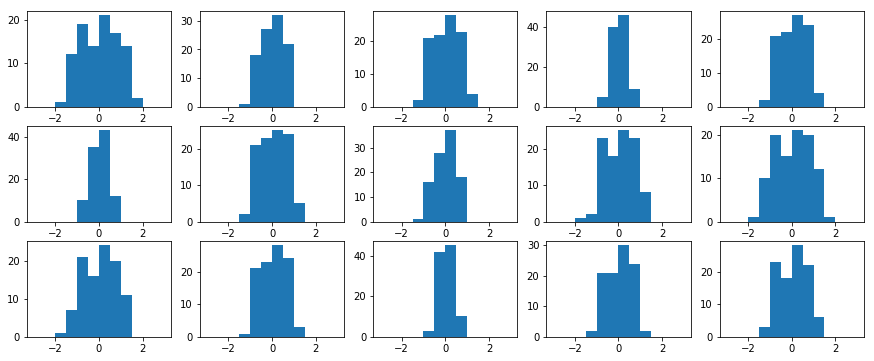

Epoch 8
[Batch 0/150]	Losses: G: 4.1796 D: 0.0500
[Batch 50/150]	Losses: G: 3.9388 D: 0.0273
[Batch 100/150]	Losses: G: 4.0935 D: 0.0140
Test losses: G: 3.8431 D: 0.0259


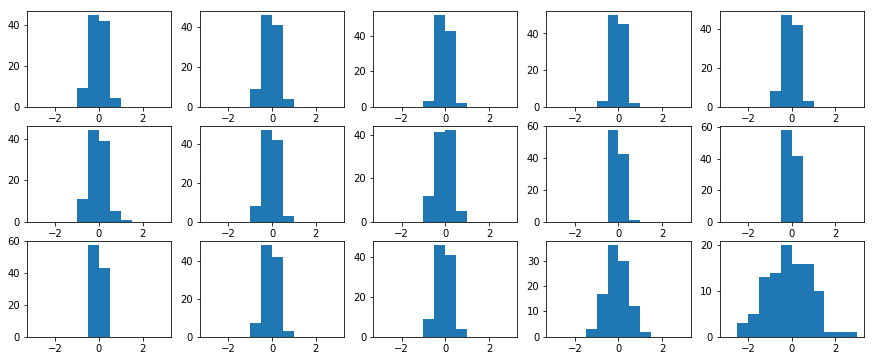

Epoch 9
[Batch 0/150]	Losses: G: 4.1563 D: 0.0375
[Batch 50/150]	Losses: G: 4.1268 D: 0.0124
[Batch 100/150]	Losses: G: 4.2158 D: 0.0138
Test losses: G: 4.0228 D: 0.0153


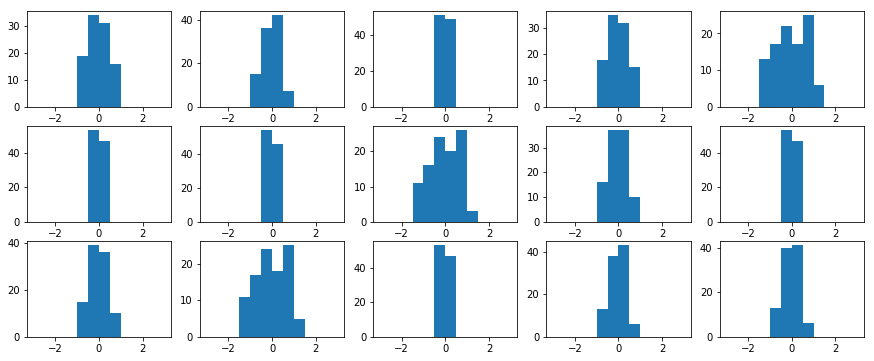

Epoch 10
[Batch 0/150]	Losses: G: 4.2883 D: 0.0385
[Batch 50/150]	Losses: G: 4.2279 D: 0.0202
[Batch 100/150]	Losses: G: 4.4491 D: 0.0390
Test losses: G: 4.2709 D: 0.0301


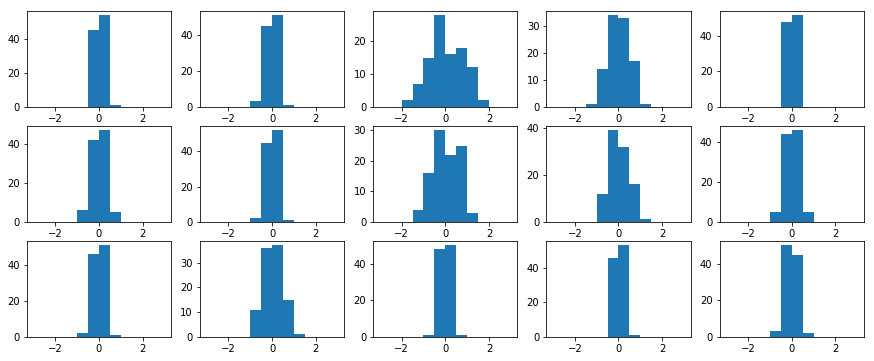

Epoch 11
[Batch 0/150]	Losses: G: 4.4396 D: 0.0173
[Batch 50/150]	Losses: G: 4.9367 D: 0.0159
[Batch 100/150]	Losses: G: 5.2565 D: 0.0110
Test losses: G: 4.6825 D: 0.0098


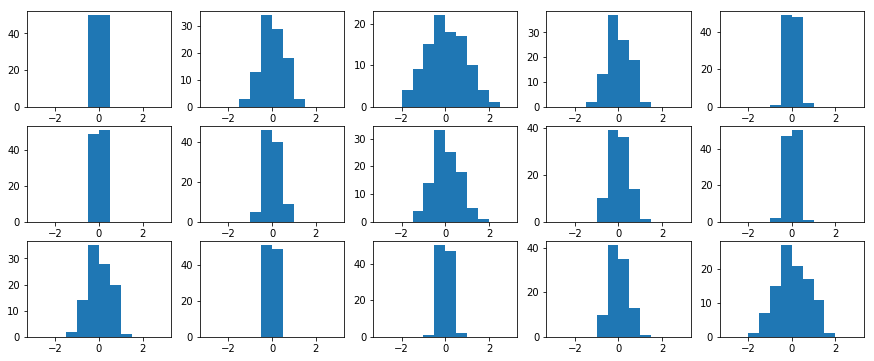

Epoch 12
[Batch 0/150]	Losses: G: 5.0550 D: 0.0405
[Batch 50/150]	Losses: G: 5.3286 D: 0.0070
[Batch 100/150]	Losses: G: 5.9671 D: 0.0308
Test losses: G: 5.5237 D: 0.0106


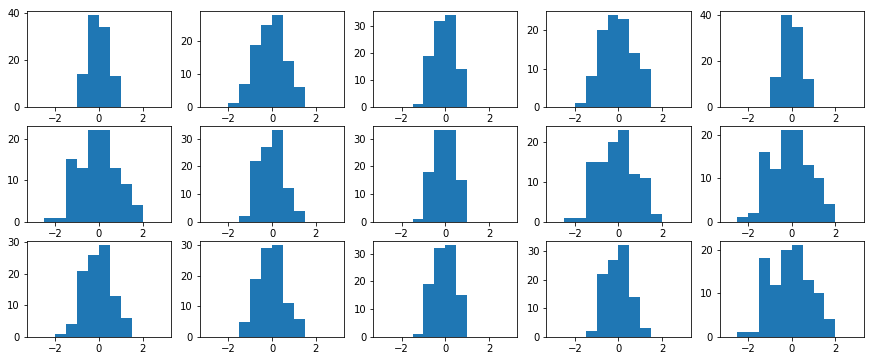

Epoch 13
[Batch 0/150]	Losses: G: 6.0681 D: 0.0025
[Batch 50/150]	Losses: G: 5.7513 D: 0.0115
[Batch 100/150]	Losses: G: 6.3463 D: 0.0419
Test losses: G: 5.3683 D: 0.0237


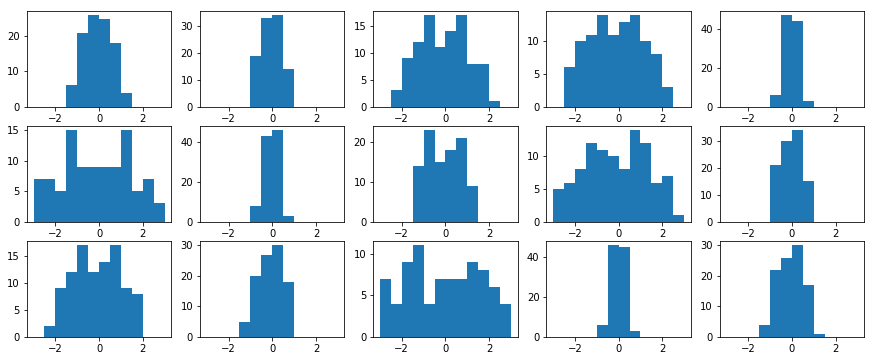

Epoch 14
[Batch 0/150]	Losses: G: 6.5934 D: 0.0048
[Batch 50/150]	Losses: G: 6.6043 D: 0.0118
[Batch 100/150]	Losses: G: 7.2705 D: 0.0119
Test losses: G: 6.6216 D: 0.0034


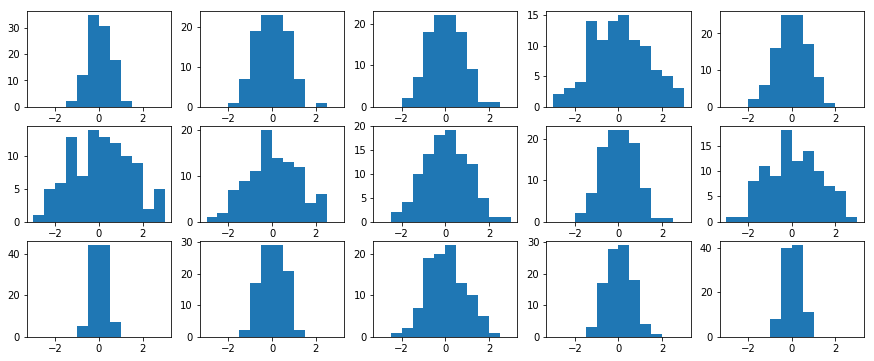

Epoch 15
[Batch 0/150]	Losses: G: 7.3217 D: 0.0150
[Batch 50/150]	Losses: G: 6.8039 D: 0.0096
[Batch 100/150]	Losses: G: 7.4181 D: 0.0016
Test losses: G: 6.5202 D: 0.0104


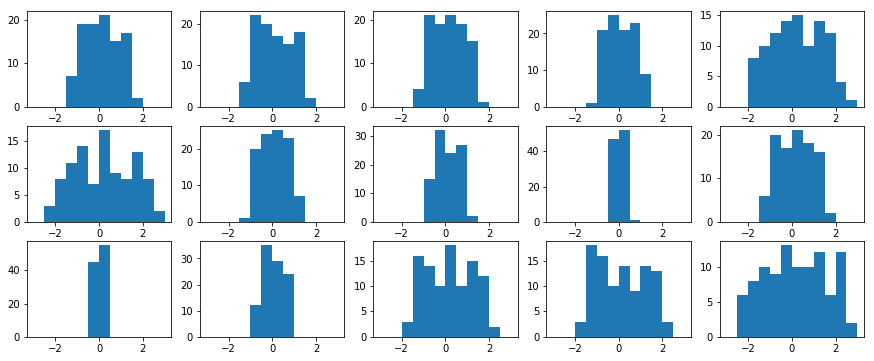

Epoch 16
[Batch 0/150]	Losses: G: 7.5306 D: 0.0054
[Batch 50/150]	Losses: G: 7.6139 D: 0.0722
[Batch 100/150]	Losses: G: 7.6216 D: 0.0128
Test losses: G: 6.3852 D: 0.0151


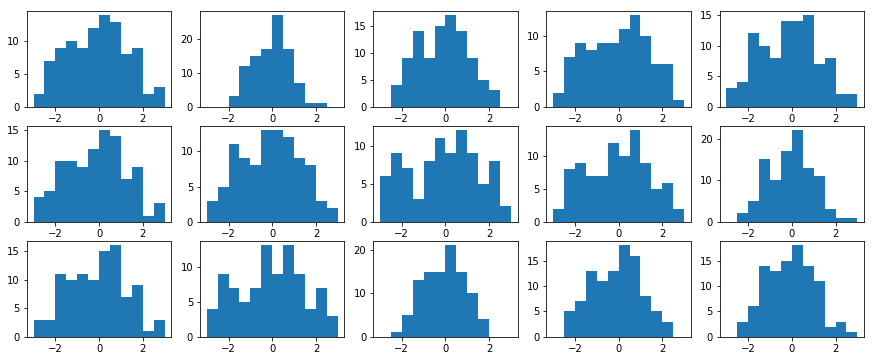

Epoch 17
[Batch 0/150]	Losses: G: 7.5478 D: 0.0080
[Batch 50/150]	Losses: G: 8.8760 D: 0.0630
[Batch 100/150]	Losses: G: 9.0088 D: 0.0023
Test losses: G: 7.7513 D: 0.0202


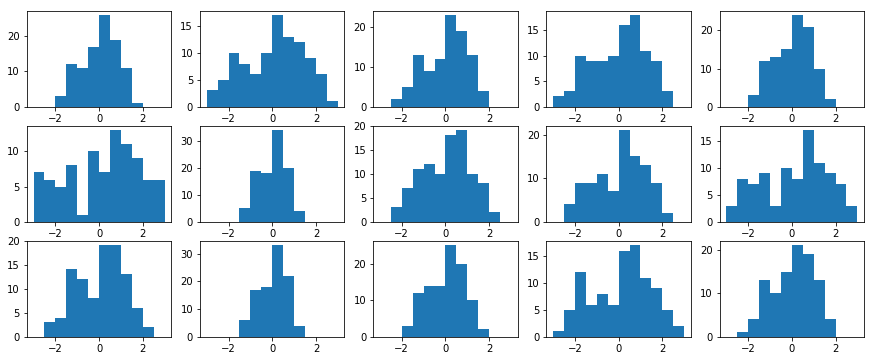

Epoch 18
[Batch 0/150]	Losses: G: 8.4786 D: 0.0126
[Batch 50/150]	Losses: G: 7.9504 D: 0.0026
[Batch 100/150]	Losses: G: 12.5524 D: 0.0083
Test losses: G: 8.6318 D: 0.0115


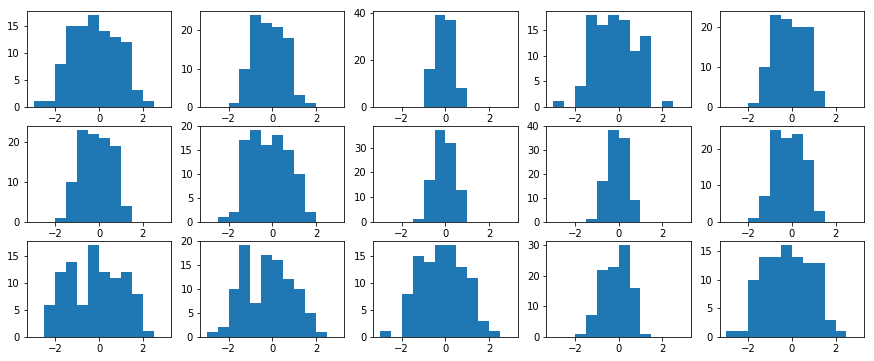

Epoch 19
[Batch 0/150]	Losses: G: 9.9484 D: 0.0030
[Batch 50/150]	Losses: G: 11.0601 D: 0.0433
[Batch 100/150]	Losses: G: 8.2733 D: 0.0023
Test losses: G: 7.2201 D: 0.0048


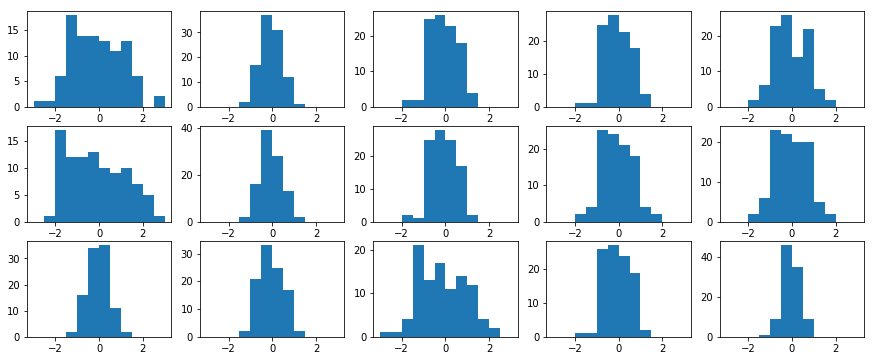

Epoch 20
[Batch 0/150]	Losses: G: 8.2629 D: 0.0031
[Batch 50/150]	Losses: G: 8.8148 D: 0.0027
[Batch 100/150]	Losses: G: 7.6677 D: 0.0049
Test losses: G: 6.5996 D: 0.0060


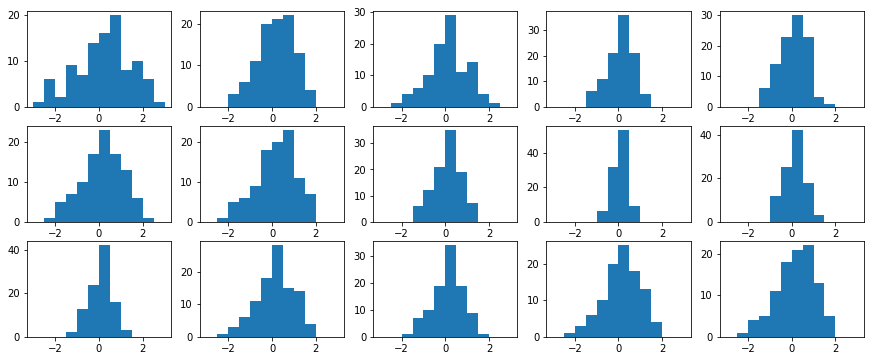

Epoch 21
[Batch 0/150]	Losses: G: 7.0949 D: 0.0097
[Batch 50/150]	Losses: G: 7.0659 D: 0.0372
[Batch 100/150]	Losses: G: 6.5894 D: 0.0024
Test losses: G: 6.7373 D: 0.0023


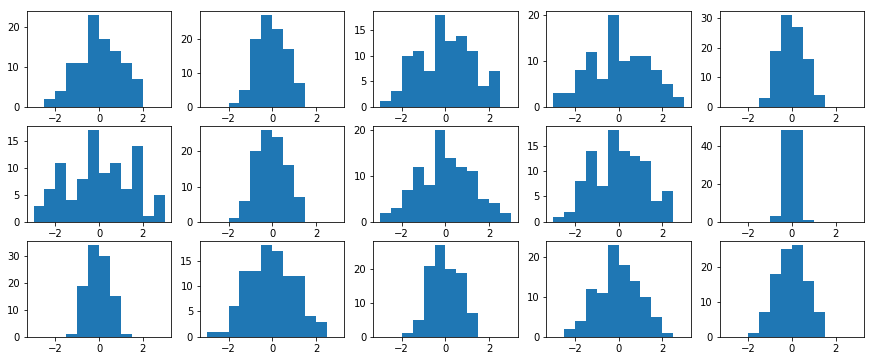

Epoch 22
[Batch 0/150]	Losses: G: 7.8455 D: 0.0011
[Batch 50/150]	Losses: G: 8.8373 D: 0.0063
[Batch 100/150]	Losses: G: 8.0022 D: 0.0118
Test losses: G: 6.6565 D: 0.0246


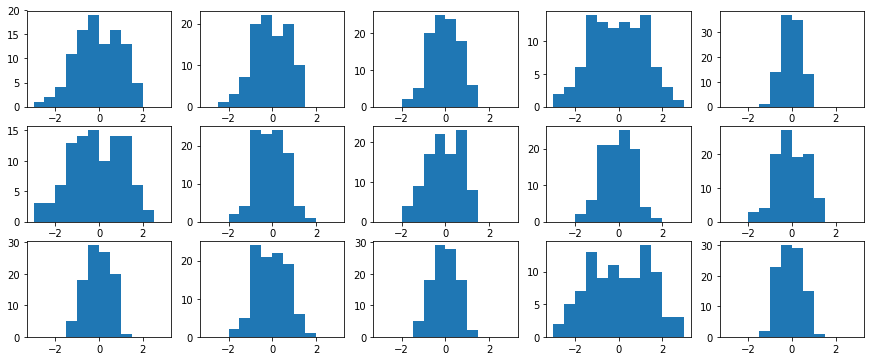

Epoch 23
[Batch 0/150]	Losses: G: 7.8561 D: 0.0093
[Batch 50/150]	Losses: G: 7.9468 D: 0.0054
[Batch 100/150]	Losses: G: 8.6484 D: 0.0039
Test losses: G: 6.7648 D: 0.0034


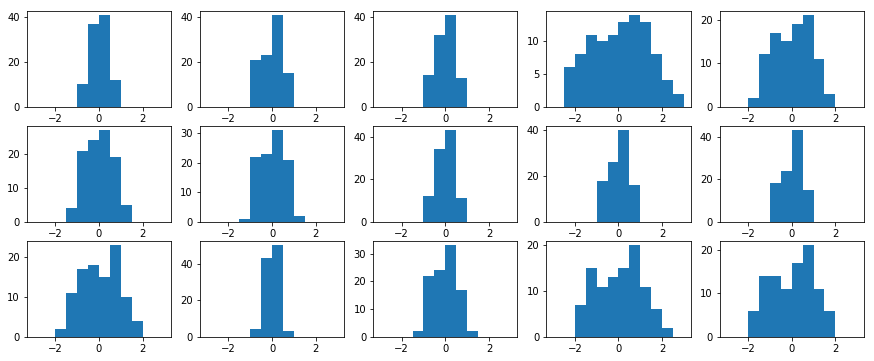

Epoch 24
[Batch 0/150]	Losses: G: 7.7691 D: 0.0030
[Batch 50/150]	Losses: G: 7.6078 D: 0.0066
[Batch 100/150]	Losses: G: 7.8107 D: 0.0049
Test losses: G: 7.0498 D: 0.0279


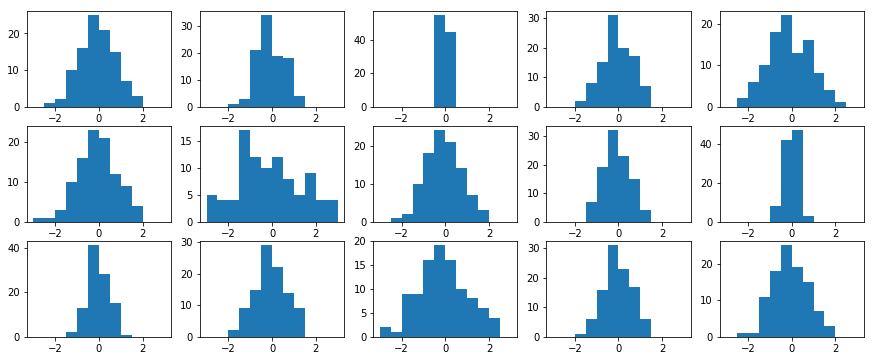

Epoch 25
[Batch 0/150]	Losses: G: 7.6486 D: 0.0087
[Batch 50/150]	Losses: G: 8.0639 D: 0.0047
[Batch 100/150]	Losses: G: 9.3972 D: 0.0100
Test losses: G: 6.4068 D: 0.0044


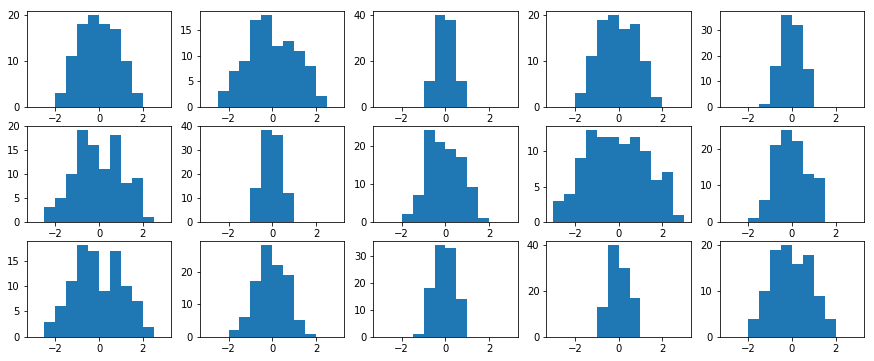

Epoch 26
[Batch 0/150]	Losses: G: 7.0441 D: 0.0025
[Batch 50/150]	Losses: G: 7.0463 D: 0.0017
[Batch 100/150]	Losses: G: 6.8783 D: 0.0016
Test losses: G: 6.3883 D: 0.0021


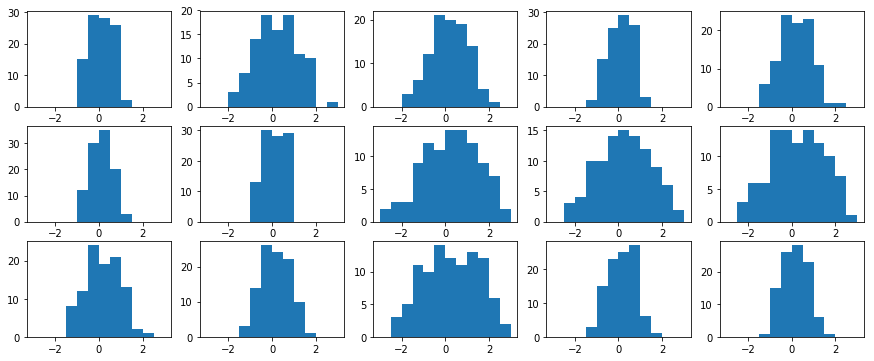

Epoch 27
[Batch 0/150]	Losses: G: 6.9860 D: 0.0157
[Batch 50/150]	Losses: G: 7.0616 D: 0.0187
[Batch 100/150]	Losses: G: 7.4494 D: 0.0009
Test losses: G: 7.0044 D: 0.0244


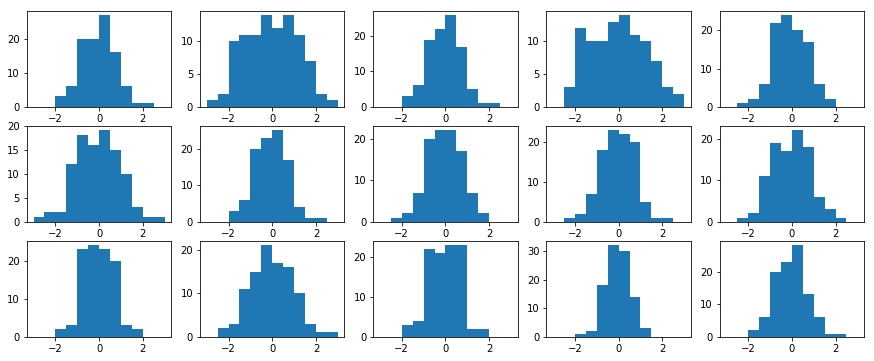

Epoch 28
[Batch 0/150]	Losses: G: 7.7148 D: 0.0153
[Batch 50/150]	Losses: G: 8.2688 D: 0.0016
[Batch 100/150]	Losses: G: 9.2633 D: 0.0024
Test losses: G: 14.4277 D: 0.0181


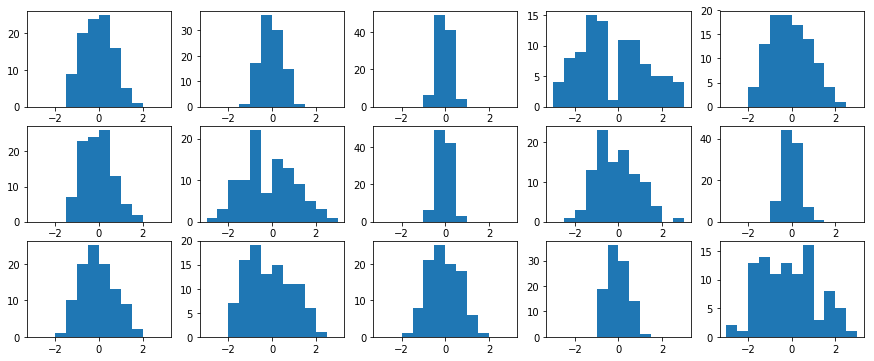

Epoch 29
[Batch 0/150]	Losses: G: 14.7869 D: 0.0081
[Batch 50/150]	Losses: G: 13.3168 D: 0.0205
[Batch 100/150]	Losses: G: 11.0592 D: 0.0006
Test losses: G: 7.2984 D: 0.0061


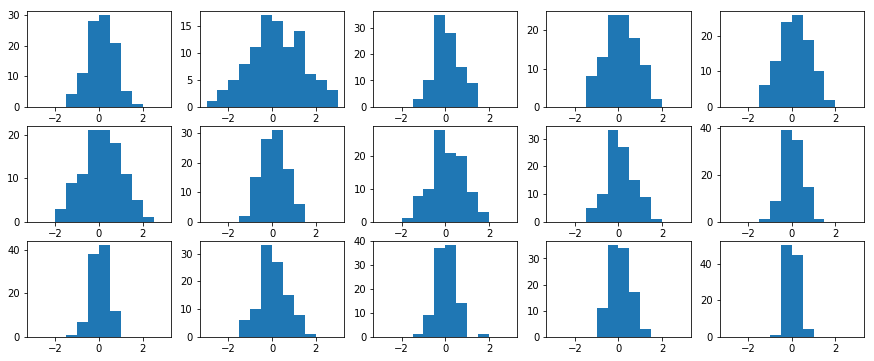

In [126]:
start_train_gan(G, D, G_optimizer, D_optimizer, 30)

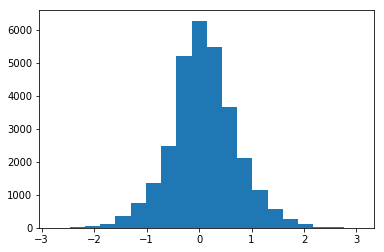

In [129]:
with torch.no_grad():
    data = G(fake_distribution.sample((300, 100))).view(-1).numpy()
    plt.hist(data, bins=20)

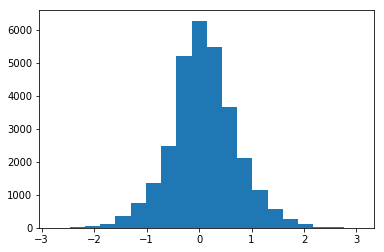

In [134]:
data = torch.empty(300 * 100).normal_().numpy()
plt.hist(data, bins=20)
plt.show()